In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import seaborn as sns

import time 
import sys 
import os
from tqdm import tqdm
import itertools
import json
import pickle

import xgboost as xgb
from xgboost import plot_tree
import lifelines

sys.path.append('./../src/')
from utils import *
from utils_xgboost import *

## config for hyperopts

In [2]:
max_depths = [5, 10, 20, 40]
learning_rates = [0.1, 0.01, 0.001]
n_estimators = [10, 50,100, 250, 500, 750, 1000, 2000]
lambdas = [0.1, 0.01, 0.001]
alphas = [0.1, 0.01]
aft_loss_distributions = [0.1, 0.5, 1.2]

In [11]:
# create the config files
for idx, element in tqdm(enumerate(itertools.product(max_depths, learning_rates, n_estimators, lambdas, alphas, aft_loss_distributions))):
    config = {'max_depth': element[0],
              'lr': element[1],
              'n_estimators': element[2],
              'lambda': element[3],
              'alpha': element[4],
              'aft_loss_distribution':element[5]}
    with open('./XGBoost_surv/configs/config_'+str(idx)+'.json','w') as f:
        json.dump(config, f)

1728it [00:01, 1098.06it/s]


## Results of hyperopts

Run XGBoost for all the hyperparameters combinations using the config files and read the results here

In [2]:
max_depths = [5, 10, 20, 40]
learning_rates = [0.1, 0.01, 0.001]
n_estimators = [10, 50,100, 250, 500, 750, 1000, 2000]
lambdas = [0.1, 0.01, 0.001]
alphas = [0.1, 0.01]
aft_loss_distributions = [0.1, 0.5, 1.2]

combinations = [i for i in itertools.product(max_depths, learning_rates, n_estimators, lambdas, alphas, aft_loss_distributions)]
ncombinations = len(combinations)
ncombinations

1728

In [ ]:
hyperopts_result = []

for idx in range(ncombinations):
    with open('../hyperopts/XGBoost_surv/results/result_config_'+str(idx)+'.pkl','rb') as f:
        result = pickle.load(f)
    f.close()
    
    result = pd.DataFrame(result).mean().to_frame().T
    result['idx'] = idx
    hyperopts_result = hyperopts_result + [result]
    
hyperopts_result = pd.concat(hyperopts_result)
hyperopts_result.sort_values('c_index_valid').to_csv('./XGBoost_surv/results/survival_tree_hyperopts_onehot_minmax.csv')
hyperopts_result.sort_values('c_index_valid')

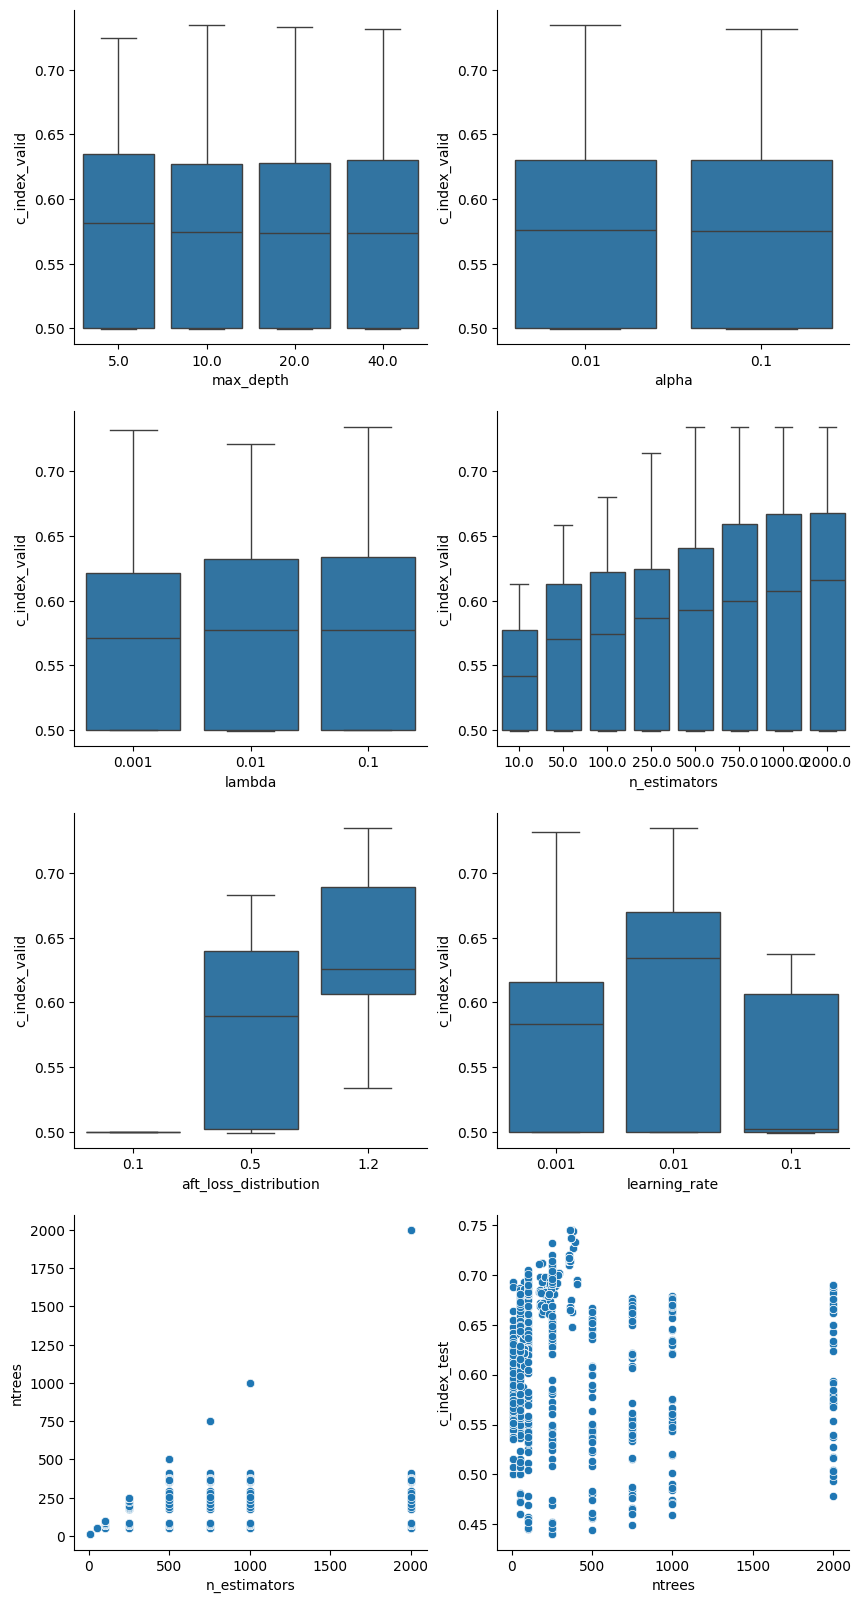

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,20))

b = sns.boxplot(data=hyperopts_result, 
                 x='max_depth', y='c_index_valid',
                 ax=axs[0][0])

b = sns.boxplot(data=hyperopts_result, 
                 x='alpha', y='c_index_valid',
                 ax=axs[0][1], ) 

b = sns.boxplot(data=hyperopts_result, 
                 x='lambda', y='c_index_valid',
                 ax=axs[1][0])

b = sns.boxplot(data=hyperopts_result, 
                 x='n_estimators', y='c_index_valid',
                 ax=axs[1][1])

b = sns.boxplot(data=hyperopts_result, 
                 x='aft_loss_distribution', y='c_index_valid',
                 ax=axs[2][0])

b = sns.boxplot(data=hyperopts_result, 
                 x='learning_rate', y='c_index_valid',
                 ax=axs[2][1])

b = sns.scatterplot(data=hyperopts_result, 
                x='n_estimators',y='ntrees', 
                 ax=axs[3][0])

b = sns.scatterplot(data=hyperopts_result, 
                 y='c_index_test',x='ntrees',
                 ax=axs[3][1])

sns.despine(top=True,right=True)